In [1]:
import uproot3
import pandas as pd 
import ROOT
from ROOT import TMath, TChain
import time
import numpy as np
import root_pandas as rp
import math
import matplotlib.pyplot as plt 
from matplotlib.ticker import AutoMinorLocator 

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


Welcome to JupyROOT 6.24/06


In [4]:
f = ROOT.TFile.Open("RootFiles/splitMC.root")
treeS=f.Get("SignalTrain")
treeB=f.Get("BackgroundTrain")

In [6]:
df1=pd.DataFrame(columns=('mll', 'lead', 'sublead'))
df2=pd.DataFrame(columns=('mll', 'lead', 'sublead'))
k=0
for event in treeS:
    df1.loc[k]=[treeS.mll,treeS.lead,treeS.sublead]
    k+=1
    if(k==40000): break
        
k=0
for event in treeB:
    df2.loc[k]=[treeB.mll,treeB.lead,treeB.sublead]
    k+=1
    if(k==40000): break

In [7]:
data={}
samples=['Signal','Background']
df_all=[df1,df2]
for i in range(len(samples)):
    frames=[]
    data_all=pd.DataFrame()
    data_all=data_all.append(df_all[i])
    frames.append(data_all)
    data[samples[i]]=pd.concat(frames)

In [8]:
data_for_BDT = {} # define empty dictionary to hold dataframes that will be used to train the BDT
BDT_inputs = ['mll', 'lead','sublead']#'InvMassZ2','FourLeptonSystemPt','FourLeptonSystemMass']# list of features for BDT
for key in data: # loop over the different keys in the dictionary of dataframes
    data_for_BDT[key] = data[key][BDT_inputs].copy()
data_for_BDT

{'Signal':              mll       lead    sublead
 0      83.241081  50.097565  34.146080
 1      88.288010  50.539906  28.266872
 2      90.001915  44.840797  44.087513
 3      96.053658  45.912575  44.105106
 4      86.702248  45.175327  31.083399
 ...          ...        ...        ...
 39995  90.778984  46.100395  44.628002
 39996  86.669647  41.244904  35.272049
 39997  91.130753  45.298264  41.389484
 39998  96.199944  38.519154  37.780735
 39999  90.694046  31.749424  30.306047
 
 [40000 rows x 3 columns],
 'Background':              mll        lead    sublead
 0      93.204437  124.174240  36.407166
 1      86.358315   52.469830  42.395828
 2      88.770370   50.000759  37.587879
 3      92.450806   45.091682  37.807648
 4      96.653496   51.936882  44.763012
 ...          ...         ...        ...
 39995  91.831940   98.248123  20.313194
 39996  95.679977   45.683998  40.858223
 39997  91.012138   47.353706   7.718978
 39998  93.069725   48.618248  29.383535
 39999  87.18478

In [9]:
all_MC = [] # define empty list that will contain all features for the MC
for key in data: # loop over the different keys in the dictionary of dataframes
    if key!='data': # only MC should pass this
        all_MC.append(data_for_BDT[key]) # append the MC dataframe to the list containing all MC features
X = np.concatenate(all_MC) # concatenate the list of MC dataframes into a single 2D array of features, called X
#print(X)
all_y = [] # define empty list that will contain labels whether an event in signal or background
for key in data: # loop over the different keys in the dictionary of dataframes
    if key!='Signal' and key!='data': # only background MC should pass this
        all_y.append(np.zeros(data_for_BDT[key].shape[0])) # background events are labelled with 0
all_y.append(np.ones(data_for_BDT['Signal'].shape[0])) # signal events are labelled with 1
y = np.concatenate(all_y) # concatenate the list of lables into a single 1D array of labels, called y
print(y)

[0. 0. 0. ... 1. 1. 1.]


In [24]:
from sklearn.model_selection import train_test_split

# make train and test sets
X_train,X_test, y_train,y_test = train_test_split(X, y, 
                                                  test_size=0.5, 
                                                  random_state=492 )

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(max_depth=2) # maximum depth of the tree
bdt = AdaBoostClassifier(dt,
                        algorithm='SAMME', # SAMME discrete boosting algorithm
                        n_estimators=12, # max number of estimators at which boosting is terminated
                        learning_rate=0.5) # shrinks the contribution of each classifier by learning_rate

start = time.time() # time at start of BDT fit
bdt.fit(X_train, y_train) # fit BDT to training set
elapsed = time.time() - start # time after fitting BDT
print("Time taken to fit BDT: "+str(round(elapsed,1))+"s") # print total time taken to fit BDT
print(bdt)

Time taken to fit BDT: 0.6s
AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.5, n_estimators=12)


In [27]:
from sklearn.metrics import classification_report, roc_auc_score
y_predicted = bdt.predict(X_test) # get predicted y for test set
print (classification_report(y_test, y_predicted,
                            target_names=["background", "signal"]))
print ("Area under ROC curve for test data: %.4f"%(roc_auc_score(y_test,
                                                    bdt.decision_function(X_test))) )

              precision    recall  f1-score   support

  background       0.78      0.92      0.85     19942
      signal       0.90      0.74      0.82     20058

    accuracy                           0.83     40000
   macro avg       0.84      0.83      0.83     40000
weighted avg       0.84      0.83      0.83     40000

Area under ROC curve for test data: 0.8859


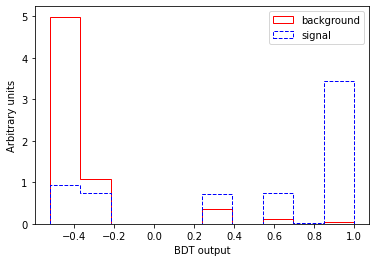

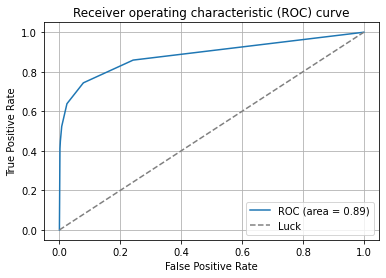

In [28]:
# we first plot the Neural Network output
signal_decisions = bdt.decision_function(X[y>0.5]).ravel() # get probabilities on signal
background_decisions = bdt.decision_function(X[y<0.5]).ravel() # get decisions on background

plt.hist(background_decisions, color='red', label='background', 
         histtype='step', # lineplot that's unfilled
         density=True ) # normalize to form a probability density
plt.hist(signal_decisions, color='blue', label='signal', 
         histtype='step', # lineplot that's unfilled
         density=True, # normalize to form a probability density
         linestyle='--' ) # dashed line
plt.xlabel('BDT output') # add x-axis label
plt.ylabel('Arbitrary units') # add y-axis label
plt.legend() # add legend


# we then plot the ROC
plt.figure() # make new figure 

from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test).ravel() # get probabilities on test set

# Compute ROC curve and area under the curve
fpr, tpr, _ = roc_curve(y_test, # actual
                        decisions ) # predicted

# Compute area under the curve for training set
roc_auc = auc(fpr, # false positive rate 
              tpr) # true positive rate

plt.plot(fpr, tpr, label='ROC (area = %0.2f)'%(roc_auc)) # plot test ROC curve
plt.plot([0, 1], # x from 0 to 1
         [0, 1], # y from 0 to 1
         '--', # dashed line
         color='grey', label='Luck')

plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.title('Receiver operating characteristic (ROC) curve') # title
plt.legend() # add legend
plt.grid() # add grid